Libraries and Useful functions

In [22]:
library("haven")
library("lfe")
library("miceadds")
library("estimatr")
library("quantreg")
library("qte")

round_auto <- function(number) {
    
    if(is.nan(number)){ return(number)}
    
    if(number == 0){
        return(0)
    }
    
    dist <- as.integer(log10(abs(number))) #number of zeros after decimal point
    res <- round(number,digits = 2)
    
    if(dist == 0){
        res = round(number, digits = 3)
    }
    
    if(dist<0) {
        res = round(number, digits = abs(dist) + 2)
    }
    return(res)
}

### Context  

In the following, I have attempted to reproduce the results from the paper "The Miracle of Microfinance? Evidence from a Randomized Evaluation" (doi: 10.1257/app.20130533). The data was available at following link: https://www.openicpsr.org/openicpsr/project/113599/version/V1/view 

Treatment - Microfinance institutions (MFIs) were opened by Spandana in 52 out of 104 poor neighbourhoods of Hyderabad, India.
First endline - 15-18 months after treatment
Second endline - 2 years after first endline. 

During the exepriment, other MFIs also opened in both treatment and control neighbourhoods. However, usage of credit was higher (p<0.01) in treated areas compared to non-treated areas and hence the analysis could be performed.

# Data Aquisition and Exploration

In [2]:
data_loc <- "data//microfinance//"

In [3]:
census_data <- read_dta(paste0(data_loc, "2013-0533_data_census.dta"))
baseline_data <- read_dta(paste0(data_loc, "2013-0533_data_baseline.dta"))
endline_data <- read_dta(paste0(data_loc, "2013-0533_data_endlines1and2.dta"))
el_business_data <- read_dta(paste0(data_loc, "2013-0533_data_endline1businesstype.dta"))


In [4]:
baseline_data <- baseline_data[order(baseline_data$hhid_baseline, decreasing = FALSE), ]
baseline_data <- baseline_data[order(baseline_data$areaid, decreasing = FALSE), ]

#Remove areas not relevant in experiment (areas with high migrant population)
baseline_data <- baseline_data[baseline_data$area_dropped == 0, ]

Due to expediency requirements, the baseline survey was not performed rigorously and hence author's felt that the sample was not representative. Hence, baseline survey was used for stratification and to obtain control variables at area level, but was not used for treatment effect analysis.

In [5]:
attr_pct = 100.0*sum(endline_data$sample2 == 0) / sum(endline_data$sample1 == 1)
attr_pct = paste0(round_auto(attr_pct), "%")
print(paste0("Attrition between two endlines = ", attr_pct))

[1] "Attrition between two endlines = 10.51%"


In [7]:
options(repr.plot.width=8, repr.plot.height=6)

compare_baseline_data_binary <- function(name, title_plot){
    treatment_bdata <- baseline_data[baseline_data$treatment == 1,][[name]]
    control_bdata <- baseline_data[baseline_data$treatment == 0,][[name]]
    
    
    average_val = c(sum(treatment_bdata, na.rm = TRUE)/sum(!is.na(treatment_bdata)) ,
                    sum(control_bdata, na.rm = TRUE)/sum(!is.na(control_bdata)) )
    
    group = c("treatment", "control")
    colors = c("red", "blue")
    
    barplot(height = average_val, names.arg = group, col = colors, ylim = c(0,1))
    title(title_plot)
}

compare_baseline_data_continous <- function(name, title_plot){
    treatment_bdata <- baseline_data[baseline_data$treatment == 1,][[name]]
    control_bdata <- baseline_data[baseline_data$treatment == 0,][[name]]
    
    treatment_bdata <- treatment_bdata[!is.na(treatment_bdata)]
    control_bdata <- control_bdata[!is.na(control_bdata)]
    
    
    b = min(c(treatment_bdata, control_bdata))
    e = max(c(treatment_bdata, control_bdata))
    ax = pretty(b:e, n = 12)
    
    c1 <- rgb(255,0,0, max = 255, alpha = 120, names = "lt.pink")
    c2 <- rgb(100,0,255,max = 255, alpha = 150, names = "lt.blue")
    c_overlap <- rgb(220,0,255,max = 255, alpha = 200, names = "lt.blue")
    
    hg_treat <- hist(treatment_bdata, breaks = ax, plot = FALSE, right = FALSE) # Save first histogram data
    hg_control <- hist(control_bdata, breaks = ax, plot = FALSE, right = FALSE) # Save 2nd histogram data

    legend("topright", legend=c("treatment", "control", "overlap"),  fill = c(c1, c2, c_overlap))

    plot(hg_treat, col = c1) # Plot 1st histogram using a transparent color
    plot(hg_control, col = c2, add = TRUE) # Add 2nd histogram using different color\
    title(title_plot)
    
}

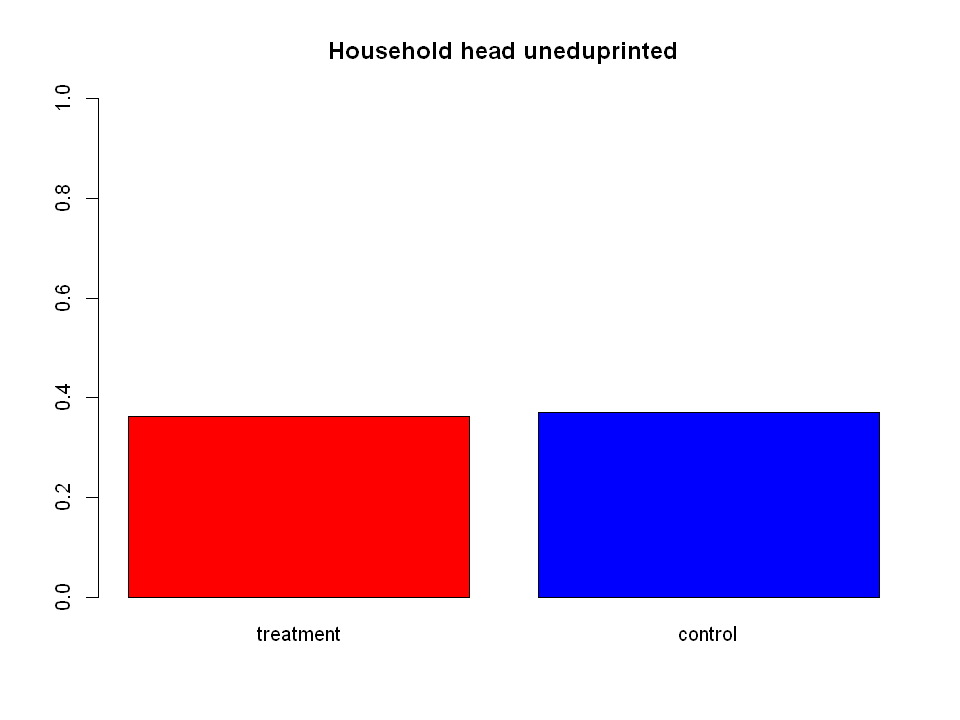

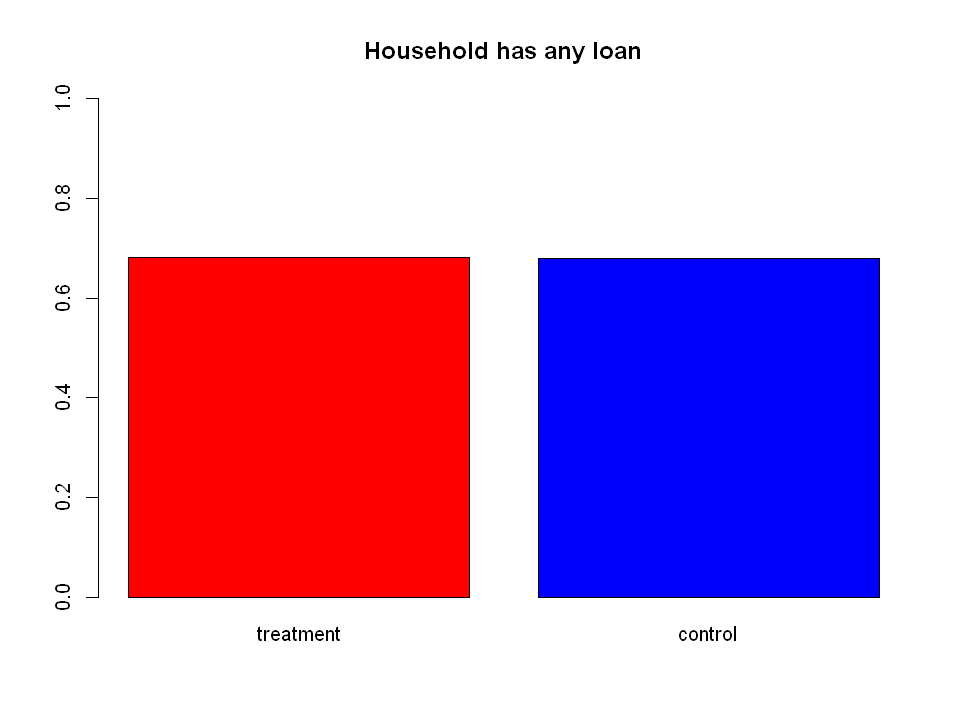

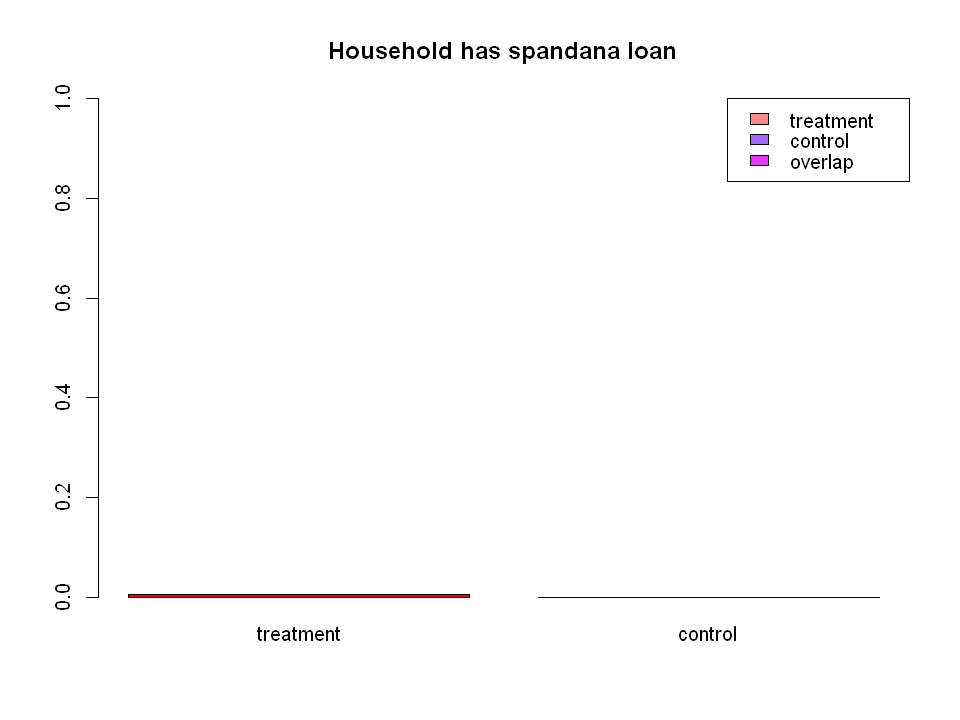

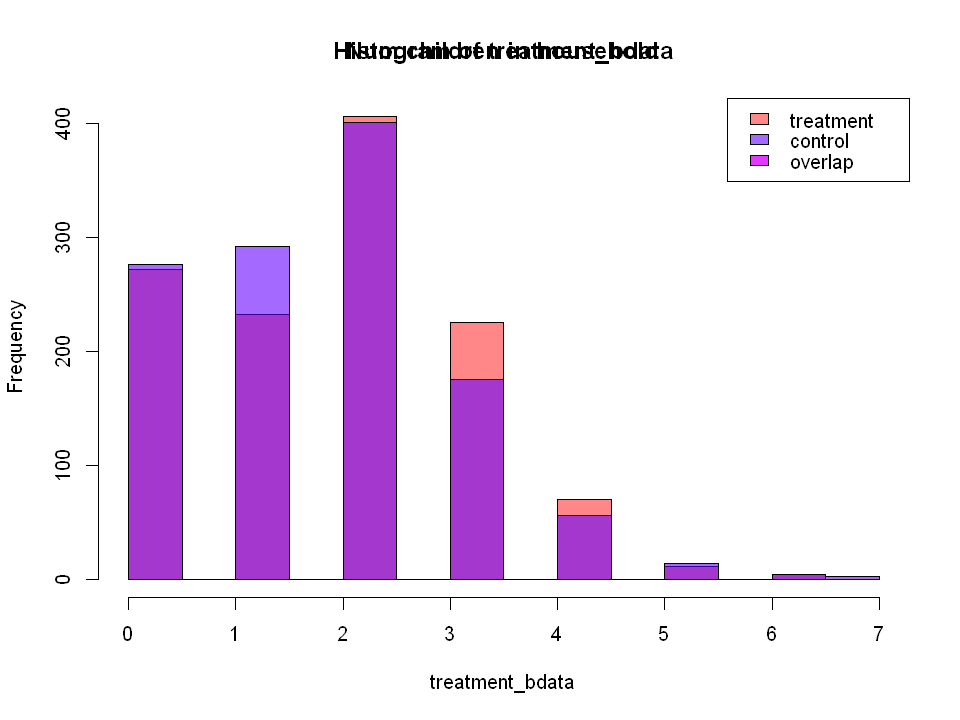

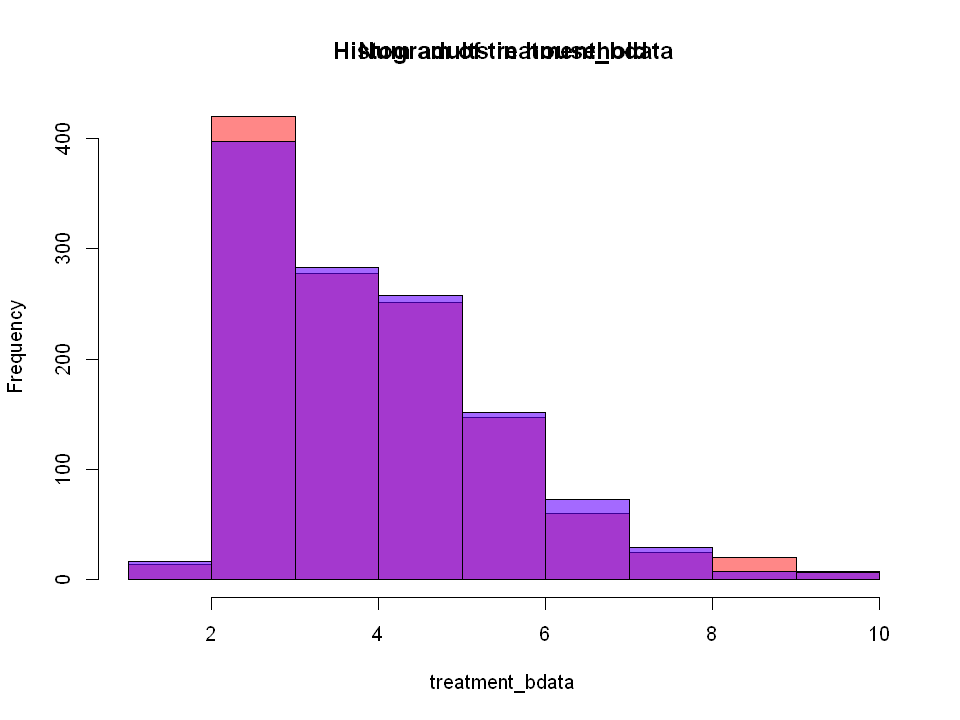

In [8]:
compare_baseline_data_binary("head_noeduc", "Household head uneduprinted")

compare_baseline_data_binary("anyloan","Household has any loan")

compare_baseline_data_binary("spandana", "Household has spandana loan")

compare_baseline_data_continous("children" ,"Num children in household")

compare_baseline_data_continous("adults", "Num adults in household")

# Baseline summary

In [11]:
baseline_summary <- function(row_list) {
    
    col_list = c("characteristic", "T_mean", "T_std", "C_mean", "C_std", "diff",  "N", "t_val", "p_pal", "sig")
    summary_res <- data.frame(matrix(nrow = 0, ncol = length(col_list)))
    colnames(summary_res) <- col_list
    
    baseline_treatment <- baseline_data[ baseline_data$treatment == 1 ,  ]
    baseline_control <- baseline_data[ baseline_data$treatment == 0 ,  ]
        
    for (name in row_list){
        
        T_mean <- mean(baseline_treatment[[name]], na.rm = TRUE)       
        T_std <- sd(baseline_treatment[[name]], na.rm = TRUE)
        
        C_mean <- mean(baseline_control[[name]], na.rm = TRUE)
        C_std <- sd(baseline_control[[name]], na.rm = TRUE)
        
        diff <- T_mean - C_mean
        
        N1 <- sum(!is.na(baseline_treatment[[name]]))
        N2 <- sum(!is.na(baseline_control[[name]]))
        
        N <- N1 + N2 
        
        
        t_val <- (diff)/sqrt(((N1-1)*T_std**2 + (N2-1)*C_std**2)/(N - 2) * (1.0/N1 + 1.0/N2))
        p_val <- 2*pt(t_val, df = N-2, lower.tail = FALSE)
#        t_val <- abs(diff)/sqrt(((N1-1)*T_std**2 + (N2-1)*C_std**2)/(N - 2) * (1.0/N1 + 1.0/N2))
#        p_val <- 1-pt(t_val, df = 102)
        
        T_mean <- round_auto(T_mean)
        T_std <- round_auto(T_std)
        C_mean <- round_auto(C_mean)
        C_std <- round_auto(C_std)
        diff <- round_auto(diff)

        t_val <- round_auto(t_val)
        p_val <- round_auto(p_val)
        
        sig <- ""
        if(p_val<0.1){sig <- "*"}
        if(p_val<0.05){sig <- "**"}
        if(p_val<0.01){sig <- "***"}
        
        summary_res[nrow(summary_res) + 1,] = c(name,T_mean, T_std, C_mean, C_std, diff ,N ,t_val,p_val,sig)
    }
    
    return(summary_res)
}


In [12]:
cat("----------------------\n Household Composition")
panel_cols <- c("hh_size", "adults", "children", "male_head", "head_age", "head_noeduc" )
baseline_summary(panel_cols)


cat("----------------------\n Access to credit")
panel_cols <- c("spandana", "othermfi", "bank", "informal", "anyloan" )
baseline_summary(panel_cols)


cat("----------------------\n Amount Borrowed")
panel_cols <- c("spandana_amt", "othermfi_amt", "bank_amt", "informal_amt", "anyloan_amt" )
baseline_summary(panel_cols)


cat("----------------------\n Self Employed Activities")
panel_cols <- c("total_biz", "female_biz", "female_biz_pct" )
baseline_summary(panel_cols)


cat(".\n.\n.\n")
cat("SIMILARLY CONTINUED")

----------------------
 Household Composition

,characteristic,T_mean,T_std,C_mean,C_std,diff,N,t_val,p_pal,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,hh_size,5.133,1.785,5.038,1.666,0.095,2440,1.36,0.174,
2,adults,3.427,1.52,3.439,1.466,-0.011,2440,-0.19,1.151,
3,children,1.703,1.242,1.599,1.228,0.104,2440,2.082,0.037,**
4,male_head,0.895,0.307,0.907,0.29,-0.012,2433,-1.011,1.688,
5,head_age,40.91,10.89,41.15,10.84,-0.243,2431,-0.553,1.419,
6,head_noeduc,0.362,0.481,0.37,0.483,-0.0077,2433,-0.394,1.306,


----------------------
 Access to credit

,characteristic,T_mean,T_std,C_mean,C_std,diff,N,t_val,p_pal,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,spandana,0.0066,0.081,0,0,0.0066,2431,2.831,0.0047,***
2,othermfi,0.017,0.13,0.011,0.103,0.0065,2431,1.37,0.171,
3,bank,0.038,0.191,0.036,0.187,0.0015,2431,0.195,0.846,
4,informal,0.634,0.482,0.632,0.482,0.0015,2431,0.077,0.938,
5,anyloan,0.682,0.466,0.68,0.467,0.0021,2431,0.113,0.91,


----------------------
 Amount Borrowed

,characteristic,T_mean,T_std,C_mean,C_std,diff,N,t_val,p_pal,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,spandana_amt,68.97,1032.82,0,0,68.97,2431,2.326,0.02,**
2,othermfi_amt,371.51,6146.87,201.15,2742.36,170.36,2431,0.882,0.378,
3,bank_amt,2018.47,19434.29,7438.17,173268.34,-5419.7,2431,-1.085,1.722,
4,informal_amt,27889.56,65814.34,28460.02,65312.16,-570.46,2431,-0.214,1.17,
5,anyloan_amt,32013.45,73222.26,37892,191291.57,-5878.56,2431,-1.001,1.683,


----------------------
 Self Employed Activities

,characteristic,T_mean,T_std,C_mean,C_std,diff,N,t_val,p_pal,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,total_biz,0.301,0.623,0.32,0.682,-0.019,2440,-0.713,1.524,
2,female_biz,0.139,0.392,0.145,0.4,-0.0066,2440,-0.409,1.317,
3,female_biz_pct,0.483,0.479,0.488,0.482,-0.0056,579,-0.14,1.111,


.
.
.
SIMILARLY CONTINUED

_______________________________________________________________________________________________________________

## Endline Discriptive Stats

In [13]:
endline_summary <- function(row_list) {
    
    col_list = c("name", "EL1_C_Obs", "EL1_C_Mean", "EL1_C_Sd", "EL2_C_Obs", "EL2_C_Mean", "EL2_C_Sd", "diff", "t_score" , "p_val", "sig")
    summary_res <- data.frame(matrix(nrow = 0, ncol = length(col_list)))
    colnames(summary_res) <- col_list
    
    EL_control <- endline_data[ endline_data$treatment == 0 ,  ]
        
    for (name in row_list){
        
        name_1 = paste0(name, "_1")
        name_2 = paste0(name, "_2")
        
        ## Formulas work as 
        
        EL1_C_Mean <- weighted.mean(EL_control[[name_1]], EL_control$w1, na.rm = TRUE)       
        #EL1_C_Sd <- sd(EL_control[[name_1]], na.rm = TRUE)  
        EL1_C_Sd <- sqrt( weighted.mean((EL_control[[name_1]] - EL1_C_Mean)**2, EL_control$w1, na.rm = TRUE) )
        EL1_C_Obs <- sum(!is.na(EL_control[[name_1]]))       
        
        EL2_C_Mean <- weighted.mean(EL_control[[name_2]], EL_control$w2,  na.rm = TRUE)       
        #EL2_C_Sd <- sd(EL_control[[name_2]], na.rm = TRUE)       
        EL2_C_Sd <- sqrt( weighted.mean((EL_control[[name_2]] - EL2_C_Mean)**2, EL_control$w2, na.rm = TRUE) )
        EL2_C_Obs <- sum(!is.na(EL_control[[name_2]]))       
        
        diff <- EL2_C_Mean - EL1_C_Mean
        
        
        std_eff = ((EL1_C_Obs * EL1_C_Sd**2) + (EL2_C_Obs * EL2_C_Sd**2)) / (EL1_C_Obs + EL2_C_Obs)
        t_sc <- abs(diff)/std_eff / sqrt(1.0/EL1_C_Obs + 1.0/EL2_C_Obs)
        p_val <- 2*pt(t_sc, df = (EL1_C_Obs + EL2_C_Obs)-2, lower.tail = FALSE )
        
        EL1_C_Mean <- round_auto(EL1_C_Mean)
        EL1_C_Sd <- round_auto(EL1_C_Sd)
        EL1_C_Obs <- round_auto(EL1_C_Obs)
        
        EL2_C_Mean <- round_auto(EL2_C_Mean)
        EL2_C_Sd <- round_auto(EL2_C_Sd)
        EL2_C_Obs <- round_auto(EL2_C_Obs)
        
        diff <- round_auto(diff)
        t_sc <- round_auto(t_sc)
        p_val <- round_auto(p_val)

        sig <- ""
        if(p_val<0.1){sig <- "*"}
        if(p_val<0.05){sig <- "**"}
        if(p_val<0.01){sig <- "***"}

        summary_res[nrow(summary_res) + 1,] = c(name, EL1_C_Obs, EL1_C_Mean, EL1_C_Sd, EL2_C_Obs, EL2_C_Mean, EL2_C_Sd, diff ,t_sc, p_val,sig)
    }
    
    return(summary_res)
}


In [14]:
cat("----------------------\n Household Composition")
panel_cols <- c("hhsize", "adults", "children", "male_head", "head_age", "head_noeduc" )
endline_summary(panel_cols)

cat("----------------------\n Access to credit")
panel_cols <- c("spandana", "othermfi", "anybank" , "anyinformal", "anyloan" )
endline_summary(panel_cols)


cat("----------------------\n Amount Borrowed")
panel_cols <- c("spandana_amt", "othermfi_amt", "bank_amt", "informal_amt", "anyloan_amt" )
endline_summary(panel_cols)


cat(".\n.\n.\n")
cat("SIMILARLY CONTINUED")

----------------------
 Household Composition

,name,EL1_C_Obs,EL1_C_Mean,EL1_C_Sd,EL2_C_Obs,EL2_C_Mean,EL2_C_Sd,diff,t_score,p_val,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,hhsize,3264,5.644,2.152,2943,6.265,2.547,0.621,4.43,9.6e-06,***
2,adults,3264,3.886,1.754,2943,4.036,1.847,0.15,1.83,0.067,*
3,children,3264,1.737,1.31,2943,1.763,1.321,0.025,0.573,0.566,
4,male_head,3261,0.894,0.307,2938,0.811,0.391,-0.083,26.75,2.9e-149,***
5,head_age,3257,41.15,10.22,2940,42.26,10.16,1.114,0.422,0.673,
6,head_noeduc,3256,0.311,0.463,2940,0.292,0.455,-0.02,3.654,0.00026,***


----------------------
 Access to credit

,name,EL1_C_Obs,EL1_C_Mean,EL1_C_Sd,EL2_C_Obs,EL2_C_Mean,EL2_C_Sd,diff,t_score,p_val,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,spandana,3247,0.048,0.214,2943,0.103,0.304,0.055,31.77,2.2e-205,***
2,othermfi,3183,0.148,0.355,2943,0.267,0.442,0.119,29.04,7e-174,***
3,anybank,3247,0.079,0.27,2943,0.073,0.26,-0.0061,3.429,0.00061,***
4,anyinformal,3247,0.761,0.427,2943,0.603,0.489,-0.158,29.69,3.2e-181,***
5,anyloan,3264,0.867,0.34,2943,0.903,0.296,0.036,13.97,1.1e-43,***


----------------------
 Amount Borrowed

,name,EL1_C_Obs,EL1_C_Mean,EL1_C_Sd,EL2_C_Obs,EL2_C_Mean,EL2_C_Sd,diff,t_score,p_val,sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,spandana_amt,3247,567.93,2837.29,2943,1446.38,5413.56,878.45,0.0019,0.998,
2,othermfi_amt,3200,1802.01,5915.19,2943,4718.36,10606.88,2916.35,0.0016,0.999,
3,bank_amt,3247,8428.59,102062.7,2943,6142.18,40429.01,-2286.41,1.4e-05,1,
4,informal_amt,3247,41025.26,77808.55,2943,32331.17,76734.02,-8694.09,5.7e-05,1,
5,anyloan_amt,3264,59778.41,133642.24,2943,88436.68,144838.23,28658.27,5.8e-05,1,


.
.
.
SIMILARLY CONTINUED

__________

# Regression Results


In the following analysis, the standard errors have been clustered at area level (treatment unit).

I should have ideally done the clustering above as well, but I do not (yet) know how to do this in R in a simple way.

In [15]:
control_variables <- c("area_pop_base" , "area_business_total_base" ,"area_exp_pc_mean_base" ,"area_literate_head_base" ,"area_literate_base")

In [16]:
endline_regressions <- function(y_name_list){
    
    col_list <- c("output", "el1_treatment_eff", "el1_std", "el1_pval", "el1_sig", "el1_obs", "el2_treatment_eff", "el2_std","el2_pval",  "el2_sig", "el2_obs")
    ret_df <- data.frame(matrix(nrow = 0, ncol = length(col_list)))
    colnames(ret_df) <- col_list
            
    for (name in y_name_list){
        
        name_1 <- paste0(name, "_1")
        name_2 <- paste0(name, "_2")
        
        fmla1 <- paste0(name_1, " ~ treatment + ")
        fmla1 <- as.formula(paste(fmla1, paste(control_variables, collapse= "+")))

        fmla2 <- paste0(name_2, " ~ treatment + ")
        fmla2 <- as.formula(paste(fmla2, paste(control_variables, collapse= "+")))

        
        model1 <- lm_robust(fmla1, se_type = 'stata', cluster = areaid, data = endline_data, weights=endline_data$w1)
        model2 <- lm_robust(fmla2, se_type = 'stata', cluster = areaid, data = endline_data, weights=endline_data$w2)
        
        
        el1_treatment_eff <- round_auto(model1$coefficients["treatment"])
        el1_std <- round_auto(model1$std.error["treatment"])
        el1_pval <-  round_auto(model1$p.value["treatment"])
        el1_obs <- model1$nobs

        el2_treatment_eff <- round_auto(model2$coefficients["treatment"])
        el2_std <- round_auto(model2$std.error["treatment"])
        el2_pval <-  round_auto(model2$p.value["treatment"])
        el2_obs <- model2$nobs

        el1_sig <- ""
        if(el1_pval<0.1){el1_sig <- "*"}
        if(el1_pval<0.05){el1_sig <- "**"}
        if(el1_pval<0.01){el1_sig <- "***"}

        el2_sig <- ""
        if(el2_pval<0.1){el2_sig <- "*"}
        if(el2_pval<0.05){el2_sig <- "**"}
        if(el2_pval<0.01){el2_sig <- "***"}

        
        ret_df[nrow(ret_df) + 1,] = c(name, el1_treatment_eff, el1_std, el1_pval, el1_sig, el1_obs, el2_treatment_eff, el2_std,el2_pval,  el2_sig, el2_obs)
        
    }
    
    return(ret_df)

}

In [17]:
cat("----------------------\n Endline Credit Access")
panel_cols <- c("spandana", "othermfi", "anymfi", "anybank", "anyinformal", "anyloan", "everlate", "mfi_loan_cycles")
endline_regressions(panel_cols)

cat("----------------------\n Endline Loan Amounts")
panel_cols <- c("spandana_amt", "othermfi_amt", "anymfi_amt", "bank_amt", "informal_amt", "anyloan_amt")
endline_regressions(panel_cols)

----------------------
 Endline Credit Access

,output,el1_treatment_eff,el1_std,el1_pval,el1_sig,el1_obs,el2_treatment_eff,el2_std,el2_pval,el2_sig,el2_obs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,spandana,0.121,0.021,1.3e-07,***,6811,0.06,0.019,0.0019,***,6142
2,othermfi,-0.012,0.023,0.607,,6657,-0.034,0.026,0.199,,6142
3,anymfi,0.078,0.027,0.0054,***,6811,0.0047,0.029,0.873,,6142
4,anybank,0.0027,0.011,0.813,,6811,0.00087,0.0087,0.921,,6142
5,anyinformal,-0.052,0.021,0.016,**,6811,-0.00028,0.018,0.988,,6142
6,anyloan,-0.023,0.014,0.092,*,6862,0.00012,0.01,0.991,,6142
7,everlate,-0.057,0.026,0.033,**,6475,0.0043,0.022,0.844,,6142
8,mfi_loan_cycles,0.077,0.042,0.067,*,6816,0.078,0.068,0.252,,5926


----------------------
 Endline Loan Amounts

,output,el1_treatment_eff,el1_std,el1_pval,el1_sig,el1_obs,el2_treatment_eff,el2_std,el2_pval,el2_sig,el2_obs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,spandana_amt,1251.18,253.38,3.1e-06,***,6811,929.5,297.01,0.0023,***,6142
2,othermfi_amt,-102.02,331.43,0.759,,6708,-175.71,613.71,0.775,,6142
3,anymfi_amt,1198.27,448.34,0.0088,***,6811,783.13,660.51,0.238,,6142
4,bank_amt,247.26,2095.85,0.906,,6811,-1070.92,1069.85,0.319,,6142
5,informal_amt,-1618,2574.89,0.531,,6811,-401.93,3058.41,0.896,,6142
6,anyloan_amt,2144.11,4578.39,0.641,,6862,1960.84,6296.66,0.756,,6142


In [18]:
cat("----------------------\n Endline Business Activities")
panel_cols <- c("bizassets", "bizinvestment", "bizexpense", "bizprofit", "any_biz")
endline_regressions(panel_cols)


----------------------
 Endline Business Activities

,output,el1_treatment_eff,el1_std,el1_pval,el1_sig,el1_obs,el2_treatment_eff,el2_std,el2_pval,el2_sig,el2_obs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,bizassets,614.02,390.54,0.119,,6800,1160.23,536.76,0.033,**,6142
2,bizinvestment,384.69,209.74,0.07,*,6800,-121.53,203.54,0.552,,6142
3,bizexpense,216.06,1058.63,0.839,,6685,-542.85,540.03,0.317,,6116
4,bizprofit,377.28,317.87,0.238,,6239,540.87,365.75,0.142,,6090
5,any_biz,0.0054,0.022,0.805,,6810,0.021,0.023,0.374,,6142


___________

# Hetrogeneity Analysis

In [19]:
output_name <- "informal_amt_1"

fmla <- paste0(output_name, " ~ treatment + ")
fmla <- as.formula(paste(fmla, paste(control_variables, collapse= "+")))

fmla
print("-------------------------------------")

relevant_data <- endline_data[!is.na(endline_data[[output_name]]), ] 

informal_amt_1 ~ treatment + area_pop_base + area_business_total_base + 
    area_exp_pc_mean_base + area_literate_head_base + area_literate_base

[1] "-------------------------------------"


Lets assume a uniform treatment effect and see the differences in CDF of treatment and control group

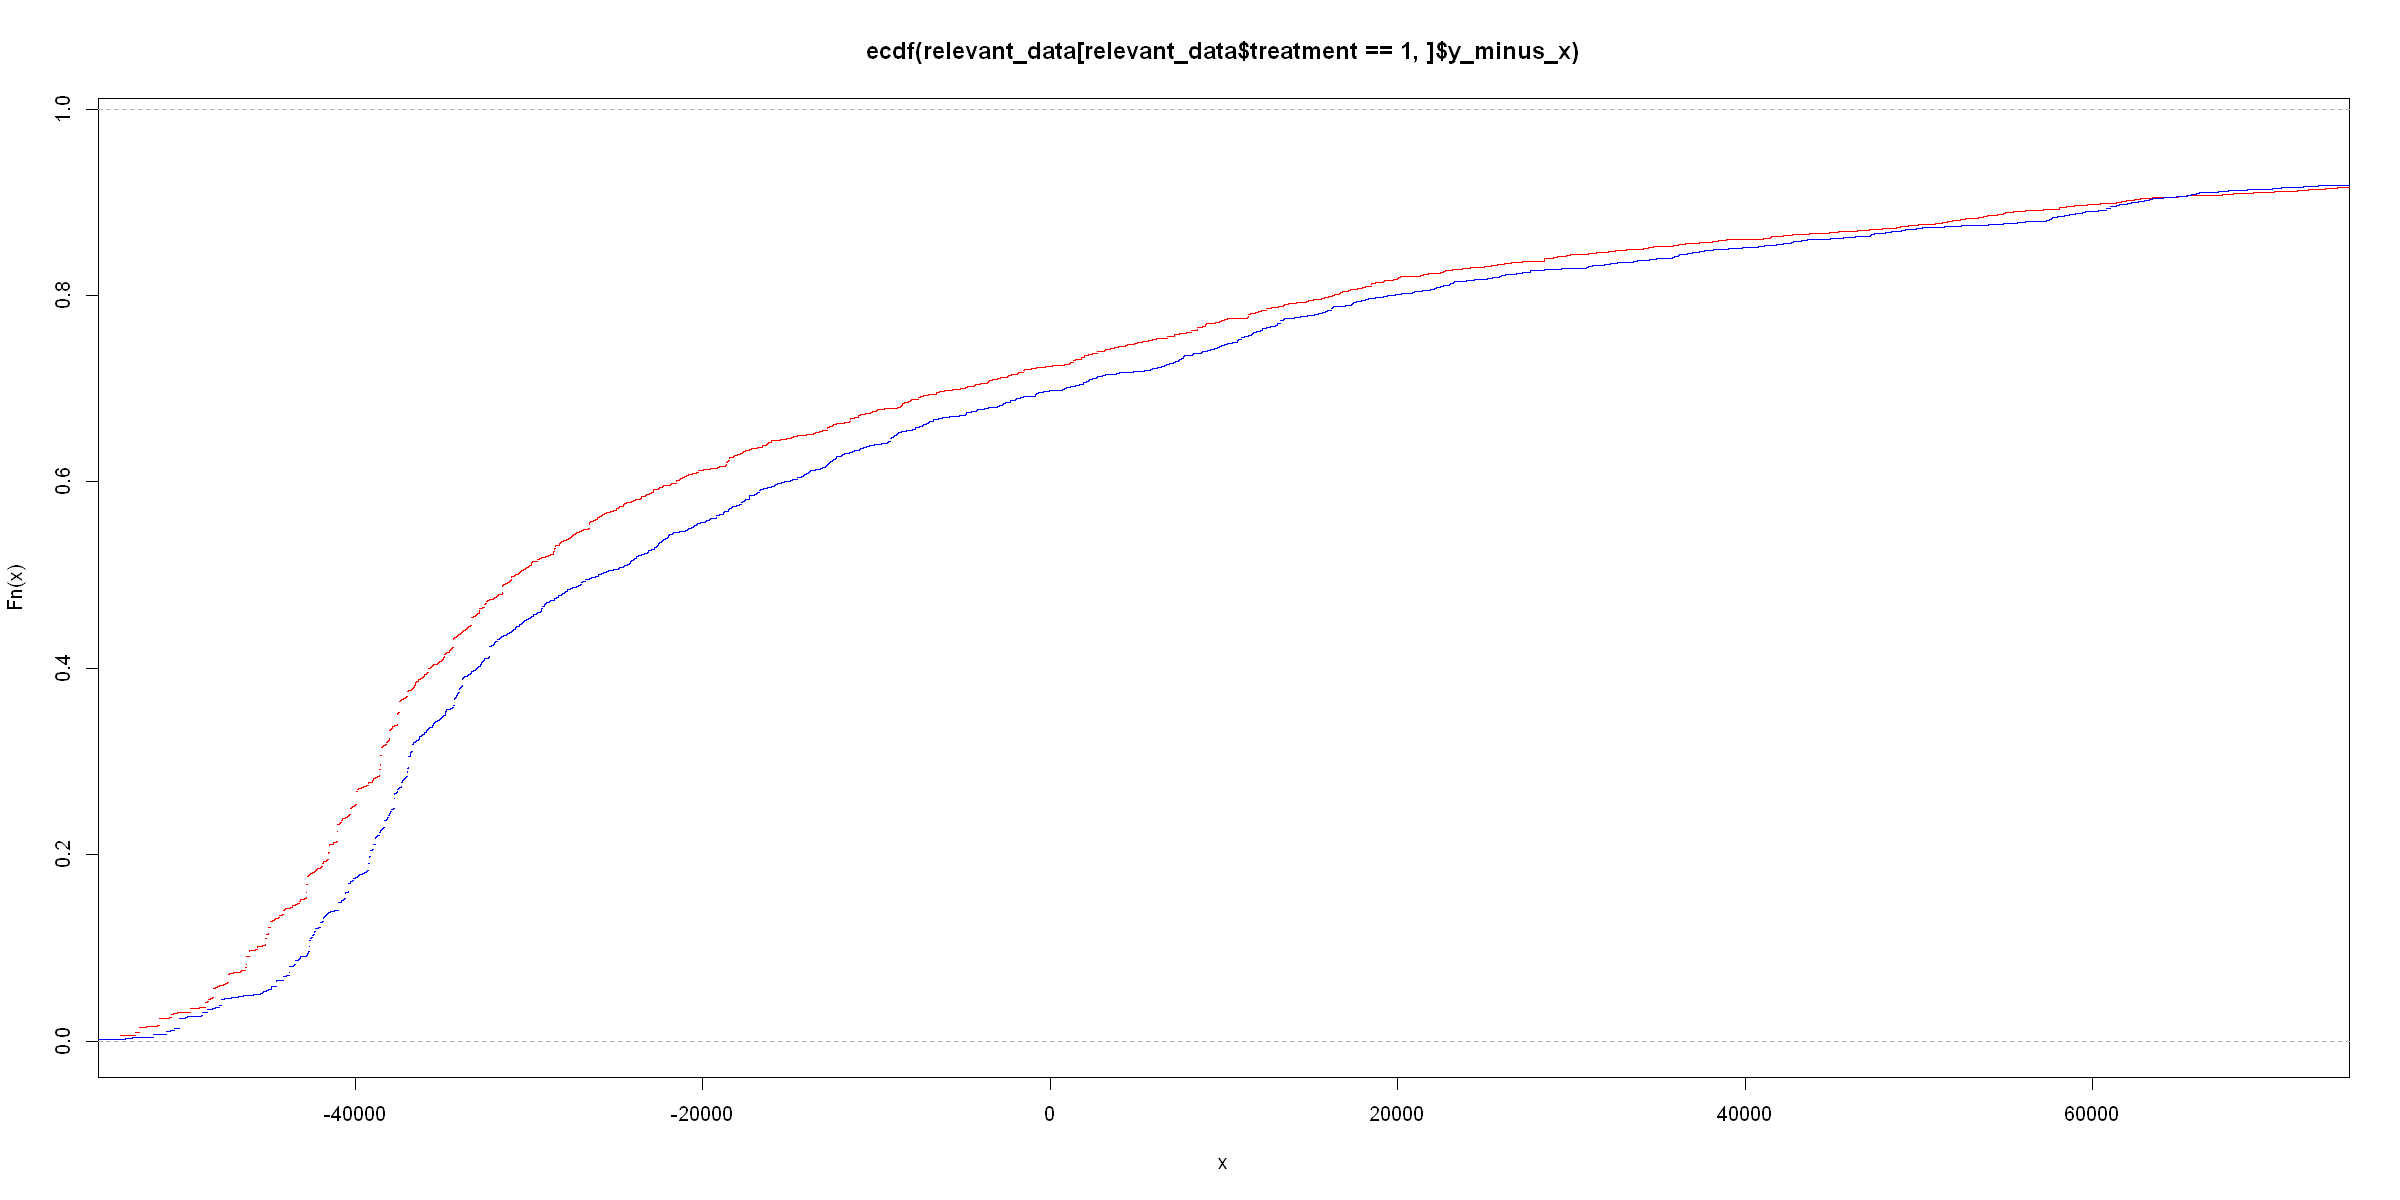

In [20]:
lm_model <- lm_robust(fmla, se_type = 'stata', cluster = areaid, data = relevant_data, weights=relevant_data$w1)

residuals <- relevant_data[[output_name]] - unname(lm_model$fitted.values)
relevant_data$y_minus_x <- residuals + unname(lm_model$coefficients["treatment"])*relevant_data$treatment

cdf_treated <- ecdf(relevant_data[relevant_data$treatment == 1, ]$y_minus_x )
cdf_control <- ecdf(relevant_data[relevant_data$treatment == 0, ]$y_minus_x )

options(repr.plot.width=20, repr.plot.height=10)

plot(cdf_treated, col = "red", xlim = c(-50000, 70000))
lines(cdf_control, col = "blue")

options(repr.plot.width=8, repr.plot.height=6)

Strongly indicates that there is hetrogeneity in the treatment effect on informal borrowing.

Lets plot the treatment effect by quantiles.

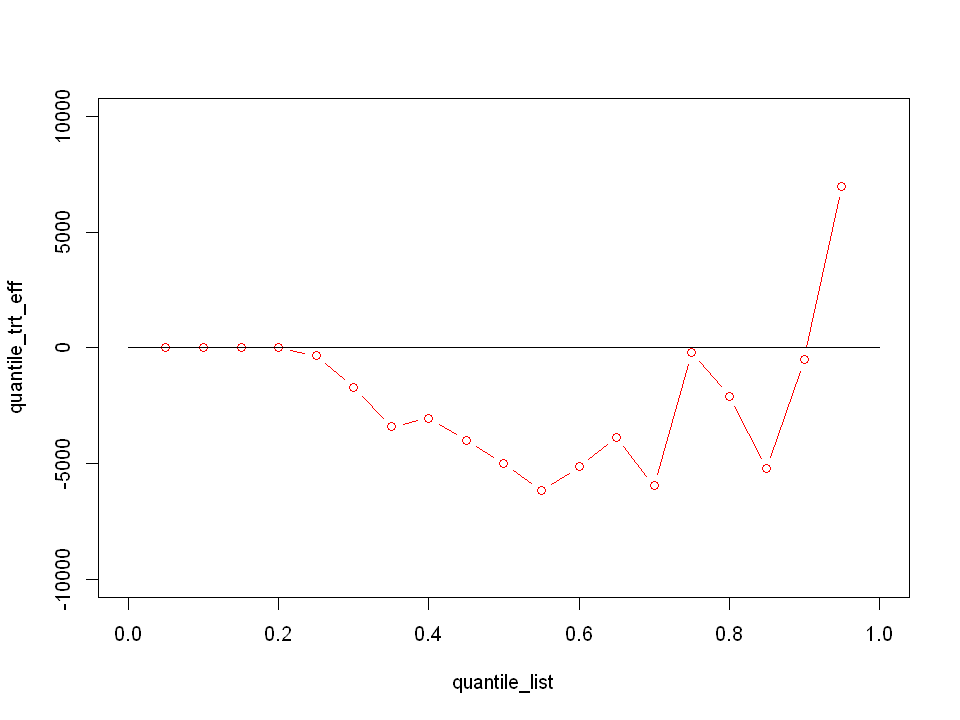

In [21]:
quantile_list <- seq(0.05, 0.95, by = 0.05)
qte_model <- ci.qtet(fmla, data=relevant_data, w = relevant_data$w1, probs=quantile_list,  se=T, iters=20)

quantile_trt_eff <- qte_model$qte 


plot(quantile_list,quantile_trt_eff, type = "b", xlim = c(0,1), ylim = c(-10000, 10000), col = "red")
lines(c(0,1), c(0,0))
